In [1]:
!apt-get  -qq  install  -y  graphviz  &&  pip  install  pydot
!pip  install  -U  matplotlib
!pip  install  git+https://github.com/fastmachinelearning/hls4ml.git@main#egg=hls4ml[profiling]
!pip  install  qkeras==0.9.0

/bin/bash: apt-get: command not found
  Cloning https://github.com/fastmachinelearning/hls4ml.git (to revision main) to /private/var/folders/3l/14rcjzxj1t3gv_xqt_53y5yw0000gn/T/pip-install-wfmaxt0a/hls4ml_3f31ee5f9e514e74a7b851298b707547
  Running command git clone --filter=blob:none --quiet https://github.com/fastmachinelearning/hls4ml.git /private/var/folders/3l/14rcjzxj1t3gv_xqt_53y5yw0000gn/T/pip-install-wfmaxt0a/hls4ml_3f31ee5f9e514e74a7b851298b707547
  Resolved https://github.com/fastmachinelearning/hls4ml.git to commit 62046d799a4dbec150addc7f78fea5b579efeda1
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
COLAB=True

In [ ]:
!pip install wget
import wget
import os.path
# WGET for colab
if not os.path.exists("callbacks.py"):
    url = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/callbacks.py"
    callbacksFile = wget.download(url)
if not os.path.exists("plotting.py"):
    urlPlot = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/plotting.py"
    plotFile = wget.download(urlPlot)

In [ ]:
if COLAB:
    if not os.path.exists("./iaifi-summer-school"):
        !git clone https://github.com/jmduarte/iaifi-summer-school.git

# Quantization

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
# import os
# os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
# for this tutorial we wont be actually running Vivado, so I have commented these lines out
#     but if you want to look into actually running on an FPGA then simply uncomment these lines

if not COLAB:
    #FOR LOCAL PULL
    X_train_val = np.load("X_train_val.npy")
    X_test = np.load("X_test.npy")
    y_train_val = np.load("y_train_val.npy")
    y_test = np.load("y_test.npy")
    classes = np.load("classes.npy", allow_pickle=True)

if COLAB:
    #FOR COLAB
    X_train_val = np.load("iaifi-summer-school/book/X_train_val.npy")
    X_test = np.load("iaifi-summer-school/book/X_test.npy")
    y_train_val = np.load("iaifi-summer-school/book/y_train_val.npy")
    y_test = np.load("iaifi-summer-school/book/y_test.npy")
    classes = np.load("iaifi-summer-school/book/classes.npy", allow_pickle=True)

## Construct a new model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models, maintained by Google.

https://github.com/google/qkeras

The convenient thing here is that the QKeras layers can be used as drop-in replacements for the corresponding Keras layers.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,...)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name="fc1",
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name="relu1"))
model.add(
    QDense(
        32,
        name="fc2",
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name="relu2"))
model.add(
    QDense(
        32,
        name="fc3",
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name="relu3"))
model.add(
    QDense(
        5,
        name="output",
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="softmax", name="softmax"))

2022-08-01 21:15:59.198655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train sparse
Let's train with model sparsity again, since QKeras layers are also prunable.

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import (
    prune,
    pruning_callbacks,
    pruning_schedule,
)
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {
    "pruning_schedule": pruning_schedule.ConstantSparsity(
        0.75, begin_step=2000, frequency=100
    )
}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the original model: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_5'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(
        optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"]
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir="model_5",
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save("model_5/KERAS_check_best_model.h5")
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model("model_5/KERAS_check_best_model.h5", custom_objects=co)

Epoch 1/30


/Users/wmccorma/miniconda3/envs/ml-iaifi/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


477/487 [============================>.] - ETA: 0s - loss: 1.3893 - accuracy: 0.4893
***callbacks***
saving losses to model_5/losses.log

Epoch 1: val_loss improved from inf to 1.19395, saving model to model_5/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.19395, saving model to model_5/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_5/KERAS_check_model_last.h5

Epoch 1: saving model to model_5/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 5s 5ms/step - loss: 1.3854 - accuracy: 0.4916 - val_loss: 1.1940 - val_accuracy: 0.6129 - lr: 1.0000e-04
Epoch 2/30
474/487 [============================>.] - ETA: 0s - loss: 1.1096 - accuracy: 0.6522
***callbacks***
saving losses to model_5/losses.log

Epoch 2: val_loss improved from 1.19395 to 1.04657, saving model to model_5/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.19395 to 1.04657, saving model to model_5/KERAS_check_best_model_weights.


Epoch 13: saving model to model_5/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.8274 - accuracy: 0.7307 - val_loss: 0.8248 - val_accuracy: 0.7308 - lr: 1.0000e-04
Epoch 14/30
482/487 [============================>.] - ETA: 0s - loss: 0.8161 - accuracy: 0.7328
***callbacks***
saving losses to model_5/losses.log

Epoch 14: val_loss improved from 0.82485 to 0.81395, saving model to model_5/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 0.82485 to 0.81395, saving model to model_5/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_5/KERAS_check_model_last.h5

Epoch 14: saving model to model_5/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.8161 - accuracy: 0.7328 - val_loss: 0.8140 - val_accuracy: 0.7327 - lr: 1.0000e-04
Epoch 15/30
470/487 [===========================>..] - ETA: 0s - loss: 0.8067 - accuracy: 0.7344

Epoch 26/30
486/487 [============================>.] - ETA: 0s - loss: 0.7568 - accuracy: 0.7462
***callbacks***
saving losses to model_5/losses.log

Epoch 26: val_loss improved from 0.76239 to 0.76026, saving model to model_5/KERAS_check_best_model.h5

Epoch 26: val_loss improved from 0.76239 to 0.76026, saving model to model_5/KERAS_check_best_model_weights.h5

Epoch 26: saving model to model_5/KERAS_check_model_last.h5

Epoch 26: saving model to model_5/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.7569 - accuracy: 0.7461 - val_loss: 0.7603 - val_accuracy: 0.7450 - lr: 1.0000e-04
Epoch 27/30
476/487 [============================>.] - ETA: 0s - loss: 0.7552 - accuracy: 0.7467
***callbacks***
saving losses to model_5/losses.log

Epoch 27: val_loss improved from 0.76026 to 0.75873, saving model to model_5/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 0.76026 to 0.75873, saving model to model_5/KERA

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned original model is shown with dashed lines.


We can also check that this performance isn't specific to some special setup in QKeras. We will use hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.

In [7]:
import hls4ml
import plotting

hls4ml.model.optimizer.get_optimizer("output_rounding_saturation_mode").layers = [
    "Activation"
]
hls4ml.model.optimizer.get_optimizer(
    "output_rounding_saturation_mode"
).rounding_mode = "AP_RND"
hls4ml.model.optimizer.get_optimizer(
    "output_rounding_saturation_mode"
).saturation_mode = "AP_SAT"

config = hls4ml.utils.config_from_keras_model(
    model, granularity="name", default_precision="ap_fixed<10,4>"
)
config["LayerName"]["softmax"]["exp_table_t"] = "ap_fixed<18,8>"
config["LayerName"]["softmax"]["inv_table_t"] = "ap_fixed<18,4>"
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir="model_5/hls4ml_prj",
    part="xcu250-figd2104-2L-e",
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: QDense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: QActivation
  -> Activation (quantized_relu), layer name: relu1
Layer name: fc2, layer type: QDense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: QActivation
  -> Activation (quantized_relu), layer name: relu2
Layer name: fc3, layer type: QDense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: QActivation
  -> Activation (quantized_relu), layer name: relu3
Layer name: output, layer type: QDense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<10,4>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<10,4>
  fc1
    Precision
      weight:        ap_fixed<6,1>
      bias:          

5188/5188 [==============================] - 3s 577us/step
Accuracy baseline:  0.7516506024096385
Accuracy pruned, quantized: 0.7460240963855421
Accuracy hls4ml: 0.7423975903614458


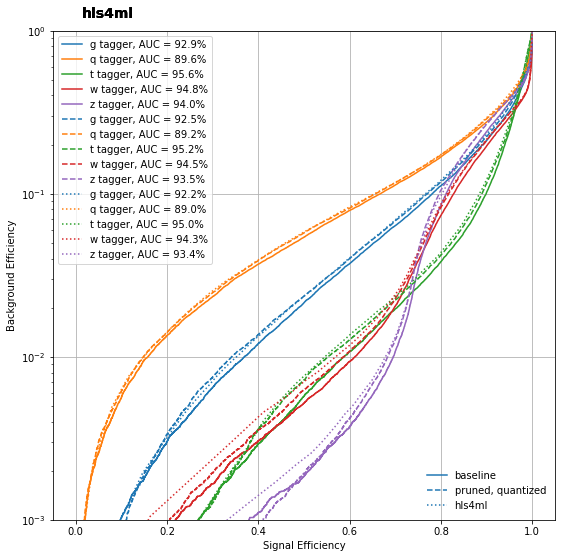

In [8]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

if not COLAB:
    model_ref = load_model("model_1/KERAS_check_best_model.h5") #locally
else:
    model_ref = load_model("iaifi-summer-school/book/model_1/KERAS_check_best_model.h5") #for colab

y_ref = model_ref.predict(X_test)

print(
    "Accuracy baseline:  {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
    )
)
print(
    "Accuracy pruned, quantized: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))
    )
)
print(
    "Accuracy hls4ml: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle="--")
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=":")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--"), Line2D([0], [0], ls=":")]
from matplotlib.legend import Legend

leg = Legend(
    ax,
    lines,
    labels=["baseline", "pruned, quantized", "hls4ml"],
    loc="lower right",
    frameon=False,
)
ax.add_artist(leg)